# UE 12
## Ziele der Übung

### 1. Weiterentwicklund des Modells beenden

- Residuallast berechnen
- Optimierungsmodell
    - mehr Zeitschritte
    - mehr Kraftwerke 
    - binäre Variable für den Kraftwerkseinsatz
    - Start-up costs
    - Speicher
- Ergebnisse plotten


### 2. Import/Export zu anderen Regionen einbauen (Gruppe A)



### 3. Must-run CHP einbauen (Gruppe B)

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

In [88]:
options = {
    "WLSACCESSID": "968327de-bce8-4d23-bdcd-f0fc20a5933d",
    "WLSSECRET": "1335c5ac-8dbb-42f0-aca8-8f1956c77e66",
    "LICENSEID": 2467020,
}

# 1. Inputs
## 1.1 Residuallast berechnen
- Last und EE-Erzeugung aus .csv-Dateien einlesen
- in Dataframe speichern und Zeitstempel erstellen
- Residuallast berechnet (Last-EE) und in neuem Dataframe speichern
- Residuallast plotten

### Last

In [89]:
# Import csv
year = 2015
path_load = './Input/Load_'+str(year)+'.csv'
#path = './Input/Load_2015.csv'

# Read from csv
df_load = pd.read_csv(path_load, sep=';', decimal=',')
df_load.tail()

,Datum,Zeit,Wert in MW
35040,31.12.2015,23:00,1632
35041,31.12.2015,23:15,1760
35042,31.12.2015,23:30,1648
35043,31.12.2015,23:45,1792
35044,31.12.2015,00:00,1664


In [90]:
# Create column including date and time
df_load['Timestamp'] = df_load['Datum']+" "+df_load['Zeit']
# Create timestamp from column
df_load['Timestamp'] = pd.to_datetime(df_load['Timestamp'], utc='Europe/Berlin', dayfirst=True)
# Set index to timestamp
df_load.set_index('Timestamp', inplace=True)
# Drop columns Datum and Zeit
df_load.drop(['Datum','Zeit'], axis=1, inplace=True)
df_load.head()

,Wert in MW
Timestamp,
2015-01-01 00:00:00+00:00,1664
2015-01-01 00:15:00+00:00,2224
2015-01-01 00:30:00+00:00,2064
2015-01-01 00:45:00+00:00,2224
2015-01-01 01:00:00+00:00,2144


### EE-Erzeugung

In [91]:
# Import csv
year = 2015
path_EE = './Input/EE_gen_'+str(year)+'.csv'
# Read from csv
df_EE = pd.read_csv(path_EE, sep=';', decimal=',')
df_EE.tail()

,cet_cest_timestamp,actual_Solar,actual_wind
35035,2015-12-31T23:45:00+0100,0.0,607.5
35036,2016-01-01T00:00:00+0100,0.0,600.9
35037,2016-01-01T00:15:00+0100,0.0,588.0
35038,2016-01-01T00:30:00+0100,0.0,579.0
35039,2016-01-01T00:45:00+0100,0.0,573.3


In [92]:
# Set datetime format
df_EE['cet_cest_timestamp'] = pd.to_datetime(df_EE['cet_cest_timestamp'], utc='Europe/Berlin')
# Set index
df_EE.set_index('cet_cest_timestamp', inplace=True)
df_EE.head()

,actual_Solar,actual_wind
cet_cest_timestamp,,
2015-01-01 00:00:00+00:00,0.0,683.4
2015-01-01 00:15:00+00:00,0.0,692.7
2015-01-01 00:30:00+00:00,0.0,692.4
2015-01-01 00:45:00+00:00,0.0,701.1
2015-01-01 01:00:00+00:00,0.0,711.3


### Residuallast

In [93]:
# Create new dataframe
df_res_load = pd.DataFrame()
df_res_load['Residuallast in MW'] = df_load['Wert in MW'] - df_EE['actual_Solar'] - df_EE['actual_wind']

df_res_load.head()

,Residuallast in MW
2015-01-01 00:00:00+00:00,980.6
2015-01-01 00:00:00+00:00,1492.6
2015-01-01 00:15:00+00:00,1531.3
2015-01-01 00:30:00+00:00,1371.6
2015-01-01 00:45:00+00:00,1522.9


### Auswahl einer Woche

In [94]:
# Create new dataframe
# Define week
week = 10
# New dataframe
df_res_load_cropped = pd.DataFrame()
# mask df_res_load
mask = (df_res_load.index.isocalendar().week == week)
# Copy df_res_load where week is 10
df_res_load_cropped = df_res_load.loc[mask]
# Resample to hourly load
df_res_load_cropped = df_res_load_cropped.resample('h').mean()

df_res_load_cropped.head()

,Residuallast in MW
2015-03-02 00:00:00+00:00,859.350
2015-03-02 01:00:00+00:00,681.375
2015-03-02 02:00:00+00:00,544.850
2015-03-02 03:00:00+00:00,358.025
2015-03-02 04:00:00+00:00,334.075


### Residuallast plotten

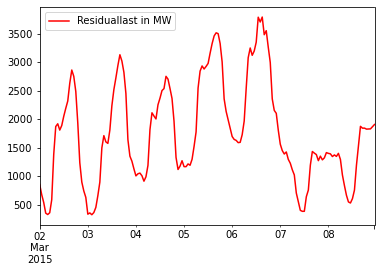

In [95]:
df_res_load_cropped.plot(kind='line', c='r', style ='-')
plt.show()

## 1.2. Preiszeitreihe im Ausland für Import und Export
- Im Input-Ordner liegen 2 Dateien mit Preiszeitreihen für die 10. Woche des Jahres 2015
- Preise "low" und Preise "high"
- Preise einlesen
- *Spoiler* Selbst die "low" Preise sind etwas zu hoch, deshalb am besten gleich ganze Preiszeitreihe mit 0.8 multiplizieren

In [96]:
# define path
price_level = 'low'
path_price = './Input/Price_'+ str(price_level)+'.csv'

# read csv
price = pd.read_csv(path_price, sep=',', decimal='.', index_col = 0, header = None, names = ['timestep', 'Preis in €/MWh'])
price = 0.8 * price.copy()
price.head()

,Preis in €/MWh
timestep,
2015-03-02 00:00:00+00:00,12.091896
2015-03-02 01:00:00+00:00,3.280788
2015-03-02 02:00:00+00:00,4.000000
2015-03-02 03:00:00+00:00,4.000000
2015-03-02 04:00:00+00:00,4.000000


- Preiszeitreihe plotten

<AxesSubplot:xlabel='timestep'>

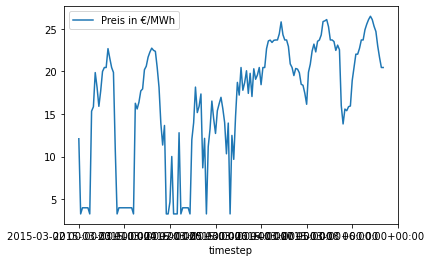

In [97]:
price.plot()

## 1.3. Wärmebedarf, der durch CHP gedeckt werden muss
- Wärmeprofil aus Input-Ordner einlesen
- cet_cest_timestamp als index setzen
- Wärmebedarf normieren, d.h. summe jeder Spalte soll 1 betragen --> entspricht Profil, was ein Jahresbedarf von 1 MWh repräsentiert
- 'DE_heat_profile_space_MFH ' verwenden und auf 500 GWh Jahresverbrauch skalieren
- auf 10. Woche des Jahres croppen

In [98]:
# Import csv
path_heat = './Input/heat_profile_2015.csv'
# Read from csv
df_heat = pd.read_csv(path_heat, sep=';', decimal=',')
df_heat.head()

,utc_timestamp,cet_cest_timestamp,DE_heat_profile_space_COM,DE_heat_profile_space_MFH,DE_heat_profile_space_SFH,DE_heat_profile_water_COM,DE_heat_profile_water_MFH,DE_heat_profile_water_SFH
0,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,212,147,161,83,71,15
1,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,217,150,166,86,69,12
2,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,233,164,176,88,66,23
3,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,241,195,202,121,105,53
4,2015-01-01T04:00:00Z,2015-01-01T05:00:00+0100,274,292,262,196,144,167


In [99]:
# Set datetime format
df_heat['cet_cest_timestamp'] = pd.to_datetime(df_heat['cet_cest_timestamp'], utc='Europe/Berlin')
# Set index
df_heat.set_index('cet_cest_timestamp', inplace=True)
df_heat.drop('utc_timestamp', axis=1, inplace=True)
df_heat.head()

,DE_heat_profile_space_COM,DE_heat_profile_space_MFH,DE_heat_profile_space_SFH,DE_heat_profile_water_COM,DE_heat_profile_water_MFH,DE_heat_profile_water_SFH
cet_cest_timestamp,,,,,,
2015-01-01 00:00:00+00:00,212,147,161,83,71,15
2015-01-01 01:00:00+00:00,217,150,166,86,69,12
2015-01-01 02:00:00+00:00,233,164,176,88,66,23
2015-01-01 03:00:00+00:00,241,195,202,121,105,53
2015-01-01 04:00:00+00:00,274,292,262,196,144,167


In [100]:
# normalize df_heat to 1 MWh yearly consumption
df_heat = (df_heat/df_heat.sum())
df_heat.head()

,DE_heat_profile_space_COM,DE_heat_profile_space_MFH,DE_heat_profile_space_SFH,DE_heat_profile_water_COM,DE_heat_profile_water_MFH,DE_heat_profile_water_SFH
cet_cest_timestamp,,,,,,
2015-01-01 00:00:00+00:00,0.000212,0.000147,0.000161,0.000083,0.000071,0.000015
2015-01-01 01:00:00+00:00,0.000217,0.000150,0.000166,0.000086,0.000069,0.000012
2015-01-01 02:00:00+00:00,0.000233,0.000164,0.000176,0.000088,0.000066,0.000023
2015-01-01 03:00:00+00:00,0.000241,0.000195,0.000202,0.000121,0.000105,0.000053
2015-01-01 04:00:00+00:00,0.000274,0.000292,0.000262,0.000196,0.000144,0.000167


In [101]:
# define yearly demand to be 500 GWh 
yearly_demand = 500000 # 500 GWh
#create new dataframe with scaled heat demand using only the profile 'DE_heat_profile_space_MFH'
df_heat_scaled = yearly_demand*df_heat['DE_heat_profile_space_MFH']

In [102]:
# crop to week 10
# New dataframe
heat_load_cropped = pd.DataFrame()
# mask dataframe with heat demand to week=10
mask = (df_heat_scaled.index.isocalendar().week == week)
heat_load_cropped = df_heat_scaled.loc[mask]

heat_load_cropped.head()

cet_cest_timestamp
2015-03-02 00:00:00+00:00     58.004814
2015-03-02 01:00:00+00:00     58.004814
2015-03-02 02:00:00+00:00     64.005312
2015-03-02 03:00:00+00:00     78.006475
2015-03-02 04:00:00+00:00    118.009795
Name: DE_heat_profile_space_MFH, dtype: float64

## 1.4. Kraftwerksparameter

In [103]:
# Define path
path_PP = './Input/PP_List.csv'
# read csv
df_PP = pd.read_csv(path_PP, sep=';', decimal=',')
df_PP

,Fuel,Pmax in MW,Pmin in MW,variable costs in EUR/MWh,startup cost in EUR,fix operating cost in EUR/h,Emissionsfaktor kg_CO2/MWh_el
0,Biomass,82,1.00,50,10,4600,0
1,Gas,1250,1.00,35,280,3800,455
2,Hard_Coal,1487,223.05,15,420,7000,891
3,Lignite,1320,264.00,6,420,7800,1225
4,Uranium,666,219.78,5,10000,11000,0
5,Oil,135,1.00,38,280,3800,776
6,Water,146,1.00,0,1,3000,0
7,CHP_Gas,200,1.00,35,280,3800,455


# 2. Modellierung
- Kraftwerksparameter aus .csv-Datei einlesen
- Modell aufstellen
    - Kraftwerksparameter definiern
    - Variablen definieren
    - Nebenbedingungen einfügen, die durch die Parameter der KW definiert werden
        - Maximale Leistung / Minimale Leistung
        - Emissionen / CO2-Kosten --> Kosten 0.02 €/kg, Limit 3.500.000.000.000.000 kg_CO2/MWh_el
        - Nachfrage
        - Start-Up Costs
        - Speicher
            - in t=0 leer
            - max. 200 MWh
    - Zielfunktion festlegen

## 2.1. Modell erstellen

In [104]:
# Create Model
env = gurobipy.Env(params=options)
M = gurobipy.Model(name= 'Unit Commitment', env=env)

# M = Model('Unit Commitment')

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2467020
Academic license 2467020 - for non-commercial use only - registered to ve___@tu-berlin.de


## 2.2. Inputdaten in Modellparameter überführen 

In [105]:
# Load
load_model = df_res_load_cropped['Residuallast in MW'].copy()

# Power Plants
PP_model = df_PP.copy()

# Pmax
P_max = PP_model['Pmax in MW']

# Pmin
P_min = PP_model['Pmin in MW']

# cost
cost_var = PP_model['variable costs in EUR/MWh']
cost_su = PP_model['startup cost in EUR']
cost_fix = PP_model['fix operating cost in EUR/h']

# emissions
e_factor = PP_model['Emissionsfaktor kg_CO2/MWh_el']
e_cost = 0.02 # in EUR/kg
e_limit = 3500000000000000 # in kg CO2

# Storage
S_max = 200 # maximales Speichervolumen in MWh
S_0 = 0 #initialer Speicherstand in t=0

# Sets for Timesteps and Powerplants
T = range(len(df_res_load_cropped))
I = range(len(df_PP))

#### Import/Export
- Kapazitätslimit der Importe/Exporte pro Stunde: 80 MWh
- Importpreis ist 5% höher als Export Preis

In [106]:
# Import/Export
capa_im_ex = 80

# Price in other market
price_im = price['Preis in €/MWh'] * 1.05
price_ex = price['Preis in €/MWh']

#### Wärme
- CHP-factor: Verhältnis zwischen Wärme und Stromoutput der CHP_Gas Kraftwerke ist 1.2

In [130]:
# define CHP factor --> ration between heat and electricity
f_CHP = 1.2 # heat output is 1.2 times electricity output

In [107]:
#heat load
heat_load_model = heat_load_cropped.copy()
heat_load_model.head()

cet_cest_timestamp
2015-03-02 00:00:00+00:00     58.004814
2015-03-02 01:00:00+00:00     58.004814
2015-03-02 02:00:00+00:00     64.005312
2015-03-02 03:00:00+00:00     78.006475
2015-03-02 04:00:00+00:00    118.009795
Name: DE_heat_profile_space_MFH, dtype: float64

## 2.3. Variablen

In [109]:
# Production
X = M.addVars(T, I, vtype=GRB.CONTINUOUS, name='Production of PP i in timestep t', lb=0.0)

# Power Plant Status, 1 = operating, 0 = not operating
Y = M.addVars(T, I, vtype=GRB.BINARY, name='Status of PP i in timestep t')

# Start-up Status, 1 = start-up, 0 = not start-up
SU = M.addVars(T, I, vtype=GRB.BINARY, name='Indicator of PP i is starting up in timestep t')

# Emissions (define variable for easier use later on)
E = M.addVars(T, I, vtype=GRB.CONTINUOUS, name='Emissions of PP i in timestep t')

# Storage
S_lvl = M.addVars(T, vtype=GRB.CONTINUOUS, name='Storage level in timestep t')
S_in = M.addVars(T, vtype=GRB.CONTINUOUS, name='Added Storage in timestep t')
S_out = M.addVars(T, vtype=GRB.CONTINUOUS, name='Storage out in timestep t')
M.update()

#### Import/Export Variablen
- Import/Export Quantities
- Import Cost / Export Revenues

In [110]:
# Import 
Im = M.addVars(T, vtype = GRB.CONTINUOUS, name = 'Import in timestep t')
C_Im = M.addVars(T, vtype = GRB.CONTINUOUS, name = 'Cost of Import in timestep t') # define variable for easier use later on

# Export
Ex = M.addVars(T, vtype = GRB.CONTINUOUS, name = 'Export in timestep t')
C_Ex = M.addVars(T, vtype = GRB.CONTINUOUS, name = 'Earning of Export in timestep t') # define variable for easier use later on
M.update()

#### Heat Variablen
- Heat output (for convenient use later)

In [133]:
# Heat output (convenient for late use)
H = M.addVars(T, vtype=GRB.CONTINUOUS, name='Heat Production of CHP in timestep t', lb=0.0)
M.update()

## 2.4. Nebenbedingungen
- Maximale und minimale Erzeugung
- Start-up Status
- Emissionen
- Speicher
    - Maximaler Speicherstand
    - Bilanz für t=0 (Level_0 = S_0 + S_in_0 - S_out_0)
    - Bilanz für jedes t > 0 (Level_t = Level_t-1 + S_in_t - S_out_t)
- Deckung der Nachfrage

In [112]:
# Erzeugung
# Pmax
M.addConstrs((X[t,i] <= P_max[i]*Y[t,i] for t in T for i in I), name='Constr 1')
# Pmin
M.addConstrs((X[t,i] >= P_min[i]*Y[t,i] for t in T for i in I), name='Constr 2')
M.update()

In [113]:
# Start-up
# t = 0 --> alle vorher aus
M.addConstrs((SU[0,i] == Y[0,i] for i in I), name='Constr 3')
# for t > 0
M.addConstrs((SU[t,i] >= Y[t,i]-Y[t-1,i] for t in T for i in I if t>0), name='Constr 4')
M.update()

In [114]:
# Emission
M.addConstrs((E[t,i] == e_factor[i]*X[t,i] for t in T for i in I), name='Constr 5')
# Limit
M.addConstr((quicksum(E[t,i] for t in T for i in I) <= e_limit), name = "Constr 6")
M.update()

In [115]:
# Speicher
# S_max
M.addConstrs((S_lvl[t] <= S_max for t in T), name='Constr 7')
# t=0
M.addConstr((S_lvl[0] == S_0 + S_in[0]-S_out[0]), name='Constr 8')
# Bilanz t>0
M.addConstrs((S_lvl[t] == S_lvl[t-1]+S_in[t]-S_out[t] for t in T if t>0), name ='Constr 9')
M.update()

#### Last

In [118]:
# Load
M.addConstrs((quicksum(X[t,i] for i in I) + S_out[t] - S_in[t] + Im[t] - Ex[t] >= load_model[t] for t in T), name='Constr 10')
M.update()

#### Import/Export
- Import/Export Kapazitätslimit
- Definition of Import Cost and Export revenues

In [116]:
# Import/Export
M.addConstrs((capa_im_ex >= Im[t] + Ex[t] for t in T), name = 'Constr 10')

# Import cost and export revenues
M.addConstrs((C_Im[t] == price_im[t] * Im[t] for t in T), name='Constr 11')
M.addConstrs((C_Ex[t] == price_ex[t] * Ex[t] for t in T), name='Constr 12')
M.update()

#### Heat
- satisfy heat demand
- Definition of heat demand for convenient later use

In [132]:
# Heat demand
M.addConstrs((X[t, 7]*f_CHP >= heat_load_model[t] for t in T), name = 'satisfy heat demand with CHP')

# Definition of Heat Output to be H[t]
M.addConstrs((H[t] == X[t, 7]*f_CHP for t in T), name='heat output')
M.update()

## 2.5. Zielfunktion

In [119]:
M.setObjective(quicksum(X[t,i]*cost_var[i] # Variable Kosten
                        + Y[t,i]*cost_fix[i] # Fixkosten, falls produziert wird
                        + SU[t,i]*cost_su[i] # Startup Kosten, falls hochgefahren wird
                        + E[t,i]*e_cost # Emissionskosten
                        - C_Ex[t] # Exporterlöse
                        + C_Im[t] # Importkosten
                        for i in I for t in T), GRB.MINIMIZE)

# 3. Optimierung

In [120]:
M.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license 2467020 - for non-commercial use only - registered to ve___@tu-berlin.de
Optimize a model with 6721 rows, 6720 columns and 17295 nonzeros
Model fingerprint: 0x9f19603b
Variable types: 4032 continuous, 2688 integer (2688 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 4e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3200 rows and 2696 columns
Presolve time: 0.05s
Presolved: 3521 rows, 4024 columns, 9959 nonzeros
Variable types: 1679 continuous, 2345 integer (2345 binary)
Found heuristic solution: objective 1.207377e+07
Found heuristic solution: objective 1.12565

alt: 9603593.834750002

no CHP: 8187285.76341279

with CHP: 8717058.89606921

# 4. Ergebnisse auslesen und visualisieren

In [121]:
print(M.objVal)
M.printAttr('X')

8717058.89606921

    Variable            X 
-------------------------
Production of PP i in timestep t[0,4]          666 
Production of PP i in timestep t[0,6]          146 
Production of PP i in timestep t[0,7]       127.35 
Production of PP i in timestep t[1,4]          666 
Production of PP i in timestep t[1,6]          146 
Production of PP i in timestep t[1,7]      48.3373 
Production of PP i in timestep t[2,4]          666 
Production of PP i in timestep t[2,7]      53.3378 
Production of PP i in timestep t[3,6]          146 
Production of PP i in timestep t[3,7]      65.0054 
Production of PP i in timestep t[4,6]          146 
Production of PP i in timestep t[4,7]      98.3415 
Production of PP i in timestep t[5,6]          146 
Production of PP i in timestep t[5,7]      100.842 
Production of PP i in timestep t[6,4]      632.301 
Production of PP i in timestep t[6,6]          146 
Production of PP i in timestep t[6,7]      94.1745 
Production of PP i in timestep t[7,3]      56

### Ergebnisse: Produktion

In [122]:
# Save production to matrix
matrix= []
for t in T:
    array = []
    for i in I:
        array.append(X[t,i].X)
    matrix.append(array)
# Convert matrix to Dataframe
Production = pd.DataFrame(matrix)
# Rename columns
Production.columns = ['Biomasse', 'Gas', 'Steinkohle', 'Braunkohle', 'Uran', 'Öl', 'Wasser', 'CHP']
# Set index to timestamp
Production.set_index(df_res_load_cropped.index, inplace=True)

Production[Production < 0] = 0
Production

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser,CHP
2015-03-02 00:00:00+00:00,0.0,0.0,0.0,0.000000,666.0,0.0,146.0,127.350000
2015-03-02 01:00:00+00:00,0.0,0.0,0.0,0.000000,666.0,0.0,146.0,48.337345
2015-03-02 02:00:00+00:00,0.0,0.0,0.0,0.000000,666.0,0.0,0.0,53.337760
2015-03-02 03:00:00+00:00,0.0,0.0,0.0,0.000000,0.0,0.0,146.0,65.005395
2015-03-02 04:00:00+00:00,0.0,0.0,0.0,0.000000,0.0,0.0,146.0,98.341496
...,...,...,...,...,...,...,...,...
2015-03-08 19:00:00+00:00,0.0,0.0,0.0,815.218256,666.0,0.0,146.0,81.256744
2015-03-08 20:00:00+00:00,0.0,0.0,0.0,1225.960579,666.0,0.0,146.0,73.339421
2015-03-08 21:00:00+00:00,0.0,0.0,0.0,1038.778215,666.0,0.0,146.0,61.671785
2015-03-08 22:00:00+00:00,0.0,0.0,0.0,1093.071265,666.0,0.0,146.0,45.003735


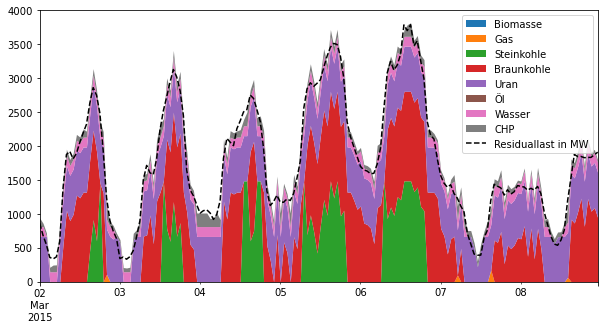

In [123]:
fig, ax = plt.subplots(figsize=(10,5))
Production.plot.area(ax=ax, stacked=True, linewidth=0)
df_res_load_cropped.plot(ax=ax, style='--', c='k')
plt.show()

### Ergebnisse: Speicher

In [124]:
# Save production to matrix
matrix= []

for t in T:
    array = []
    array.append(S_in[t].X)
    array.append(S_out[t].X)
    matrix.append(array)
    
# Convert matrix to Dataframe
Storage = pd.DataFrame(matrix)
# Rename columns
Storage.columns = ['S_in', 'S_out']
# Set index to timestamp
Storage.set_index(df_res_load_cropped.index, inplace=True)
# Convert S_in in negative values
Storage['S_in'] *= -1 #Storage['S_in']=Storage['S_in']*-1

Storage.tail()

,S_in,S_out
2015-03-08 19:00:00+00:00,-0.000000e+00,2.000000e+02
2015-03-08 20:00:00+00:00,-2.000000e+02,0.000000e+00
2015-03-08 21:00:00+00:00,-3.126388e-13,0.000000e+00
2015-03-08 22:00:00+00:00,-0.000000e+00,3.979039e-13
2015-03-08 23:00:00+00:00,-0.000000e+00,2.000000e+02


### Ergebnisse: Import/Export

In [125]:
# save Import/Export to Dataframe
matrix= []
for t in T:
    array = []
    array.append(Im[t].X)
    array.append(Ex[t].X)
    matrix.append(array)
    
# Convert matrix to Dataframe
ImEx = pd.DataFrame(matrix)
# Rename columns
ImEx.columns = ['Import', 'Export']
# Set index to timestamp
ImEx.set_index(df_res_load_cropped.index, inplace=True)
# Convert S_in in negative values
ImEx['Export'] *= -1 

ImEx.head(50)

,Import,Export
2015-03-02 00:00:00+00:00,0.000000,-80.000000
2015-03-02 01:00:00+00:00,0.000000,-73.450106
2015-03-02 02:00:00+00:00,0.000000,-80.000000
2015-03-02 03:00:00+00:00,80.000000,-0.000000
2015-03-02 04:00:00+00:00,74.923906,-0.000000
2015-03-02 05:00:00+00:00,0.000000,-0.000000
2015-03-02 06:00:00+00:00,0.000000,-80.000000
2015-03-02 07:00:00+00:00,0.000000,-80.000000
2015-03-02 08:00:00+00:00,0.000000,-80.000000
2015-03-02 09:00:00+00:00,0.000000,-80.000000


### Combine Results in one DataFrame

In [126]:
df_plot = pd.concat([Production, Storage, ImEx], axis=1)

df_plot_sorted = df_plot.reindex(df_plot.sum().sort_values(ascending=False).index, axis=1)
 
df_plot.sum()

Biomasse           0.000000
Gas              447.680029
Steinkohle     46215.830179
Braunkohle    115138.511880
Uran          106754.506615
Öl                 0.000000
Wasser         22338.000000
CHP            15995.585676
S_in           -8861.509052
S_out           8861.509052
Import          1324.402015
Export        -11735.478894
dtype: float64

### Plot final results

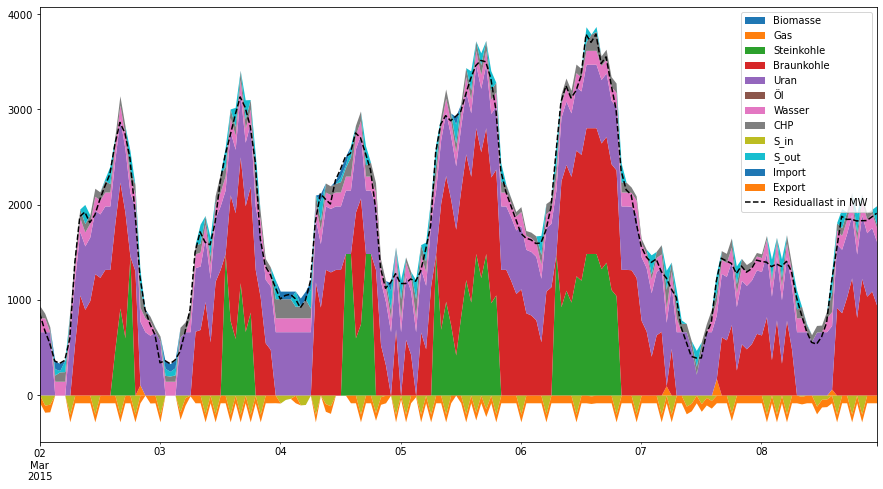

In [127]:
fig, ax = plt.subplots(figsize=(15,8))
df_plot.plot.area(ax=ax, stacked=True, linewidth=0)
df_res_load_cropped.plot(ax=ax, style='--', c='k')
plt.show()

### Ergebnisse: Emissionen

In [128]:
# Save production to matrix
matrix= []
for t in T:
    array = []
    for i in I:
        array.append(E[t,i].X)
    matrix.append(array)
# Convert matrix to Dataframe
Emissionen = pd.DataFrame(matrix)
# Rename columns
Emissionen.columns = ['Biomasse', 'Gas', 'Steinkohle', 'Braunkohle', 'Uran', 'Öl', 'Wasser', 'CHP']
# Set index to timestamp
Emissionen.set_index(df_res_load_cropped.index, inplace=True)

Emissionen[Emissionen < 0] = 0


Emissionen.tail()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser,CHP
2015-03-08 19:00:00+00:00,0.0,0.0,0.0,9.986424e+05,0.0,0.0,0.0,36971.818661
2015-03-08 20:00:00+00:00,0.0,0.0,0.0,1.501802e+06,0.0,0.0,0.0,33369.436330
2015-03-08 21:00:00+00:00,0.0,0.0,0.0,1.272503e+06,0.0,0.0,0.0,28060.662368
2015-03-08 22:00:00+00:00,0.0,0.0,0.0,1.339012e+06,0.0,0.0,0.0,20476.699566
2015-03-08 23:00:00+00:00,0.0,0.0,0.0,1.154641e+06,0.0,0.0,0.0,15736.722815


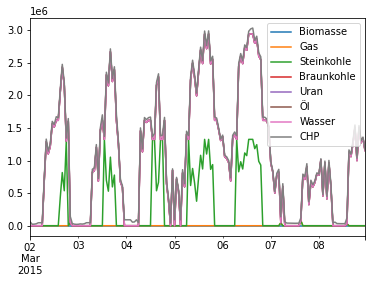

In [129]:
Emissionen.plot(stacked=True)
plt.show()